Baixando dados de: https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
Formato dos dados: (30842, 26)
['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths', 'newCases', 'totalCases', 'deathsMS', 'totalCasesMS', 'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'recovered', 'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated', 'vaccinated_per_100_inhabitants', 'vaccinated_second', 'vaccinated_second_per_100_inhabitants', 'vaccinated_single', 'vaccinated_single_per_100_inhabitants', 'vaccinated_third', 'vaccinated_third_per_100_inhabitants']
   epi_week       date country  state   city  newDeaths  deaths  newCases  \
0         9 2020-02-25  Brazil     SP  TOTAL          0       0         1   
1         9 2020-02-25  Brazil  TOTAL  TOTAL          0       0         1   
2         9 2020-02-26  Brazil     SP  TOTAL          0       0         0   
3         9 2020-02-26  Brazil  TOTAL  TOTAL     

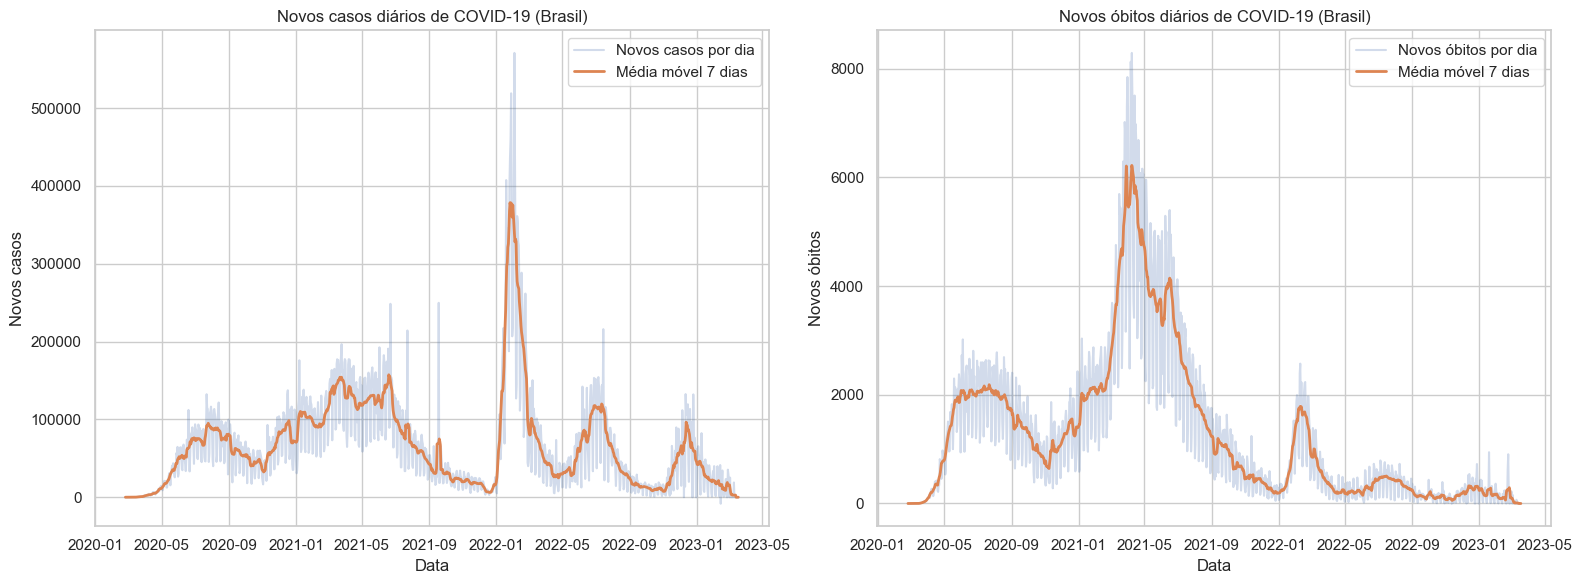

Data mais recente disponível: 2023-03-18


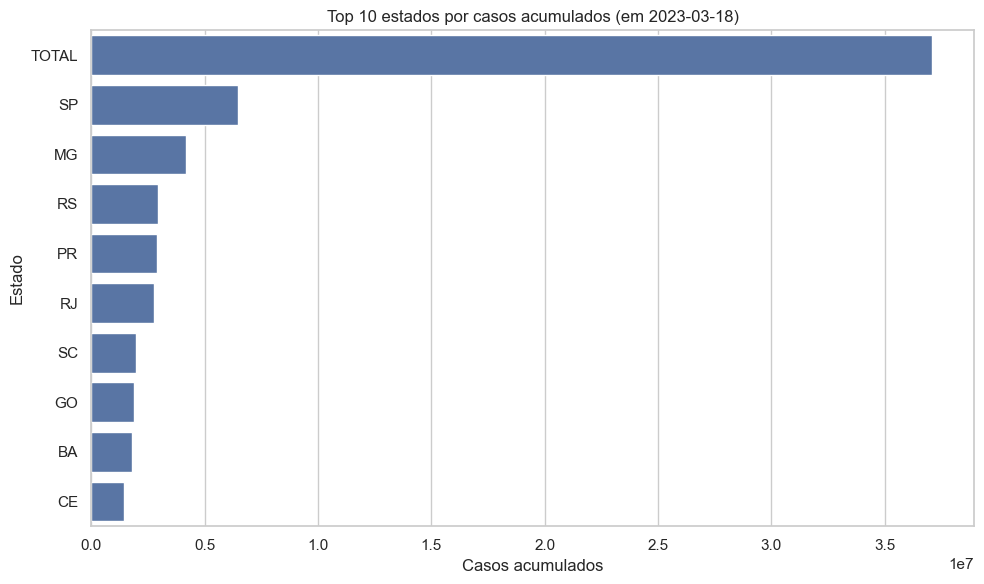

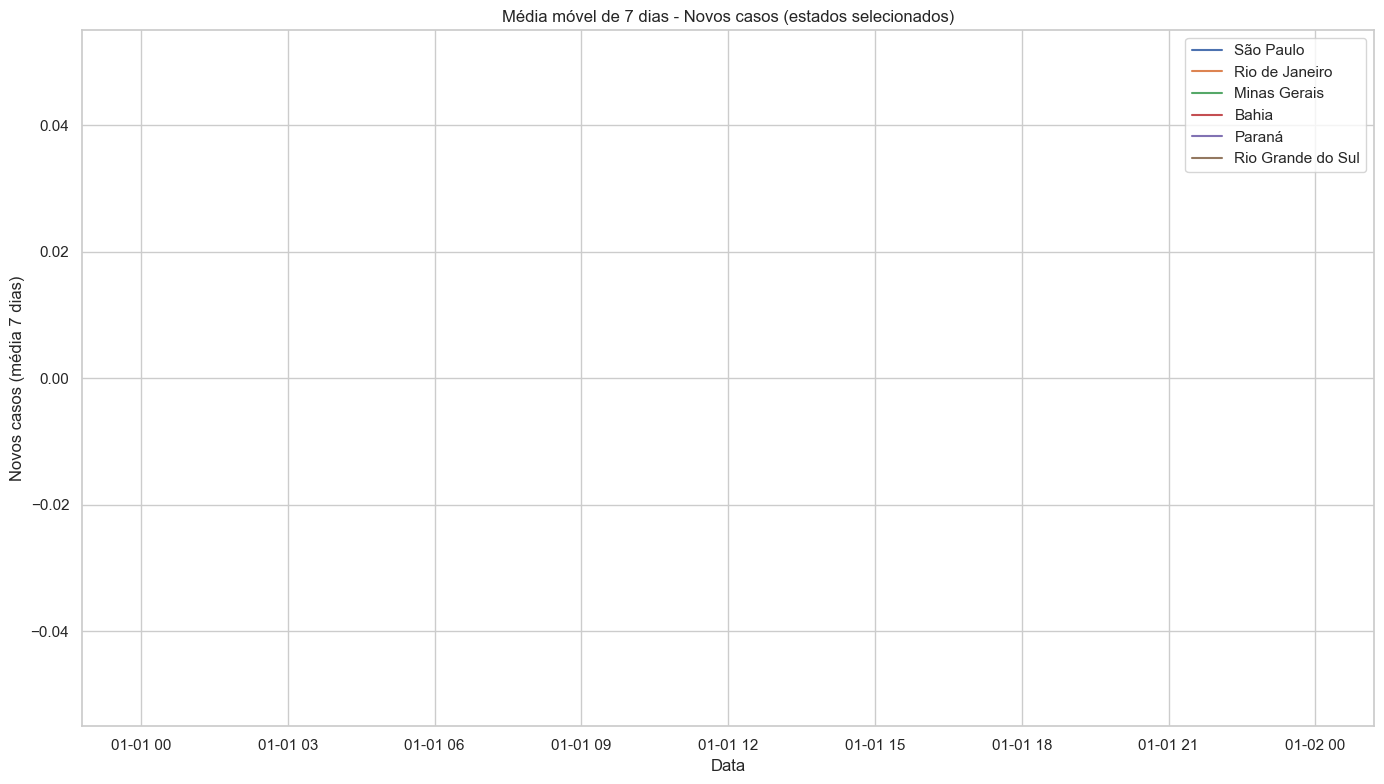

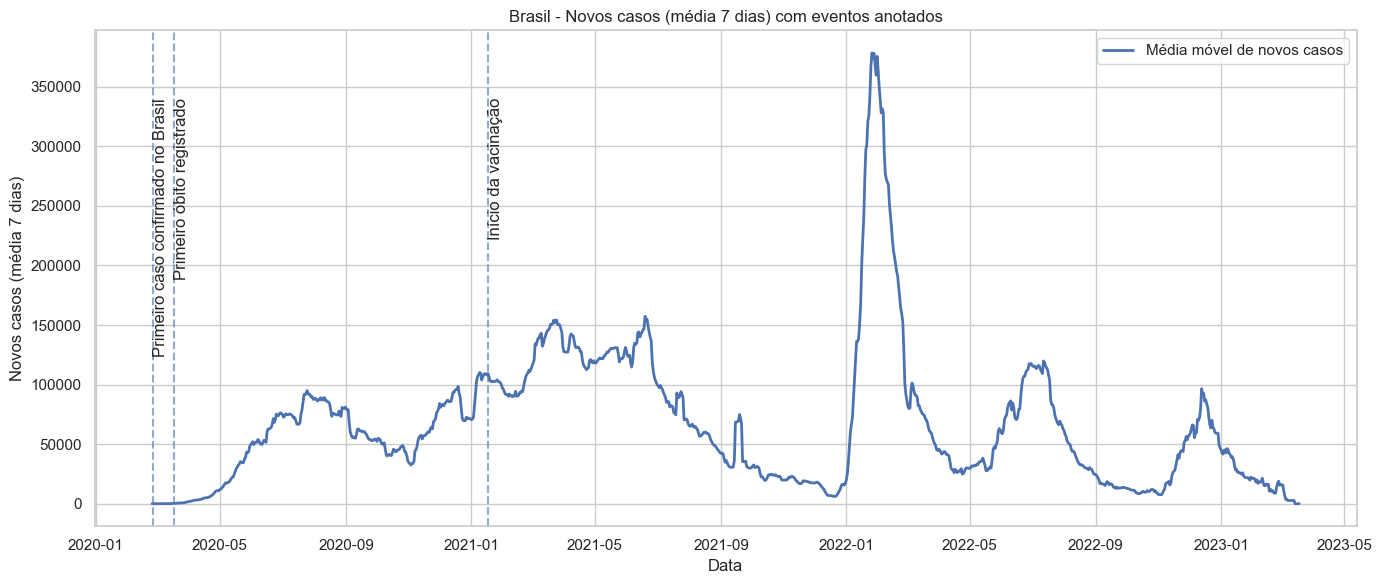


Estatísticas descritivas (Brasil):
            count          mean           std     min      25%      50%  \
newCases   1118.0  66342.611807  66717.081196 -8348.0  19865.0  49331.0   
newDeaths  1118.0   1251.001789   1442.486222    -4.0    226.5    696.0   

               75%       max  
newCases   93103.0  570792.0  
newDeaths   1859.0    8292.0  

Sugestões de narrativa:
 - O primeiro caso confirmado foi em 26/02/2020.
 - O primeiro óbito registrado ocorreu em 17/03/2020.
 - A vacinação começou em 17/01/2021, alterando a trajetória da pandemia.


In [5]:
"""
EDA & Storytelling: COVID-19 no Brasil (usando wcota/covid19br)

Problema
---------
A pandemia de COVID-19 trouxe impactos profundos ao Brasil, exigindo o acompanhamento
detalhado da evolução de casos e óbitos ao longo do tempo. A análise exploratória de dados (EDA)
é essencial para entender padrões, identificar momentos críticos e apoiar a criação de um
storytelling que conecte os dados a eventos marcantes na linha do tempo.

Solução
--------
Este notebook/script em Python implementa um pipeline de análise exploratória e storytelling:
- Baixa os dados do repositório público **wcota/covid19br** diretamente do GitHub.
- Realiza limpeza e preparação dos dados.
- Calcula estatísticas descritivas e médias móveis (7 dias).
- Gera gráficos de séries temporais nacionais e por estado, comparando casos e óbitos.
- Cria visualizações com eventos-chave anotados (ex.: primeiro caso, primeiro óbito, início da vacinação).
- Exibe os gráficos diretamente no notebook e também salva arquivos PNG e CSV para uso posterior.

Como usar
---------
- Execute este arquivo em um Jupyter Notebook ou em um ambiente Python (ex.: VSCode, Colab).
- O CSV será baixado diretamente da URL raw do GitHub. Não é necessário arquivo local.
- Altere a variável `STATE_SELECTION` para focar em diferentes estados ou cidades.

Saídas
-------
- Gráficos exibidos no notebook (séries temporais nacionais, comparação de estados, top 10 estados).
- Arquivos PNG e CSV gerados no diretório de trabalho `outputs_covid19br/`.
- Estatísticas descritivas exibidas no output do notebook.

Observações
------------
- Dataset utilizado: wcota/covid19br (cases-brazil-states.csv).
- O código é claro e modular, permitindo adaptação para outros datasets (municípios, total, vacinação).
"""

# --- Imports ------------------------------------------------------------------
import os
import io
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# --- Configuração -------------------------------------------------------------
RAW_URL = (
    "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv"
)
OUTPUT_DIR = "outputs_covid19br"
STATE_SELECTION = ["São Paulo", "Rio de Janeiro", "Minas Gerais", "Bahia", "Paraná", "Rio Grande do Sul"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Carregamento dos dados ---------------------------------------------------
print(f"Baixando dados de: {RAW_URL}")
resp = requests.get(RAW_URL)
resp.raise_for_status()

dados = pd.read_csv(io.StringIO(resp.text), parse_dates=["date"])  # parse da coluna de data
print(f"Formato dos dados: {dados.shape}")

# visão inicial
print(dados.columns.tolist())
print(dados.head())

# --- Limpeza básica -----------------------------------------------------------
dados.columns = [c.strip() for c in dados.columns]

if 'state' not in dados.columns:
    raise ValueError("Coluna 'state' não encontrada no dataset")

# Padronizar nomes de colunas (independente da versão do dataset)
colunas_map = {
    'new_confirmed': 'newCases',
    'new_deaths': 'newDeaths',
    'totalCases': 'cases',
    'totalCasesMS': 'cases',
    'deaths': 'deaths',
    'deathsMS': 'deaths'
}

for old, new in colunas_map.items():
    if old in dados.columns and new not in dados.columns:
        dados.rename(columns={old: new}, inplace=True)

# Garantir que as colunas existam
for col in ['cases', 'deaths', 'newCases', 'newDeaths']:
    if col not in dados.columns:
        dados[col] = 0

# Converter para inteiro
for col in ['cases','deaths','newCases','newDeaths']:
    dados[col] = pd.to_numeric(dados[col], errors='coerce').fillna(0).astype(int)

# --- Linha do tempo nacional --------------------------------------------------
nacional = dados.groupby('date', as_index=False).agg({'newCases':'sum', 'newDeaths':'sum', 'cases':'sum', 'deaths':'sum'})
nacional = nacional.sort_values('date')

nacional['casos_media7d'] = nacional['newCases'].rolling(window=7, center=True, min_periods=1).mean()
nacional['obitos_media7d'] = nacional['newDeaths'].rolling(window=7, center=True, min_periods=1).mean()

# Subplots: casos e óbitos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# Casos
axes[0].plot(nacional['date'], nacional['newCases'], alpha=0.25, label='Novos casos por dia')
axes[0].plot(nacional['date'], nacional['casos_media7d'], linewidth=2, label='Média móvel 7 dias')
axes[0].set_title('Novos casos diários de COVID-19 (Brasil)')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Novos casos')
axes[0].legend()

# Óbitos
axes[1].plot(nacional['date'], nacional['newDeaths'], alpha=0.25, label='Novos óbitos por dia')
axes[1].plot(nacional['date'], nacional['obitos_media7d'], linewidth=2, label='Média móvel 7 dias')
axes[1].set_title('Novos óbitos diários de COVID-19 (Brasil)')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Novos óbitos')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Top estados --------------------------------------------------------------
data_mais_recente = dados['date'].max()
print('Data mais recente disponível:', data_mais_recente.date())

estados_mais_recente = dados[dados['date']==data_mais_recente].sort_values('cases', ascending=False)

# Top 10 estados por casos
import seaborn as sns
top10 = estados_mais_recente[['state','cases']].nlargest(10, 'cases')
plt.figure(figsize=(10,6))
sns.barplot(data=top10, y='state', x='cases')
plt.title(f'Top 10 estados por casos acumulados (em {data_mais_recente.date()})')
plt.xlabel('Casos acumulados')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()

# --- Série temporal por estado selecionado ------------------------------------
sel = dados[dados['state'].isin(STATE_SELECTION)].copy()
sel = sel.sort_values(['state','date'])
sel['newCases_7d'] = sel.groupby('state')['newCases'].transform(lambda x: x.rolling(7, center=True, min_periods=1).mean())

plt.figure(figsize=(14,8))
for s in STATE_SELECTION:
    serie = sel[sel['state']==s]
    plt.plot(serie['date'], serie['newCases_7d'], label=s)

plt.title('Média móvel de 7 dias - Novos casos (estados selecionados)')
plt.xlabel('Data')
plt.ylabel('Novos casos (média 7 dias)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Linha do tempo anotada ---------------------------------------------------
EVENTOS = [
    {"date": "2020-02-26", "label": "Primeiro caso confirmado no Brasil"},
    {"date": "2020-03-17", "label": "Primeiro óbito registrado"},
    {"date": "2021-01-17", "label": "Início da vacinação"},
]

plt.figure(figsize=(14,6))
plt.plot(nacional['date'], nacional['casos_media7d'], linewidth=2, label='Média móvel de novos casos')
for ev in EVENTOS:
    ev_date = pd.to_datetime(ev['date'])
    plt.axvline(ev_date, linestyle='--', alpha=0.6)
    plt.text(ev_date, nacional['casos_media7d'].max()*0.9, ev['label'], rotation=90, va='top')

plt.title('Brasil - Novos casos (média 7 dias) com eventos anotados')
plt.xlabel('Data')
plt.ylabel('Novos casos (média 7 dias)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Estatísticas descritivas -------------------------------------------------
desc = nacional[['newCases','newDeaths']].describe().transpose()
print("\nEstatísticas descritivas (Brasil):")
print(desc)

print("\nSugestões de narrativa:")
print(" - O primeiro caso confirmado foi em 26/02/2020.")
print(" - O primeiro óbito registrado ocorreu em 17/03/2020.")
print(" - A vacinação começou em 17/01/2021, alterando a trajetória da pandemia.")